In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

### Utils

In [39]:
class Block(layers.Layer):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.h1 = models.Sequential([
            layers.Conv2D(self.filters, kernel_size=self.kernel_size, strides=1, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
        self.h2 = models.Sequential([
            layers.Conv2D(self.filters, kernel_size=self.kernel_size, strides=1, padding='same'),
            layers.BatchNormalization(),
        ])

    def call(self, x, training=False):
        x_0 = x
        h1 = self.h1(x, training=training)
        h2 = self.h2(h1, training=training)
        out = h2 + x_0
        return out

class ResidualBlock(layers.Layer):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.blocks = [Block(self.filters, self.kernel_size) for _ in range(3)]

    def call(self, x, training=False):
        x_0 = x
        for i in range(3):
            x = self.blocks[i](x, training=training)
        out = x + x_0
        return out

In [62]:
class Encoder(models.Model):
    def __init__(self, C, filters, n_blocks):
        super().__init__()
        self.C = C
        self.filters = filters
        self.n_blocks = n_blocks
        self.res_blocks = [ResidualBlock(self.filters, 3) for _ in range(self.n_blocks)]
        self.h1 = models.Sequential([
            layers.Conv2D(self.filters // 2, kernel_size=5, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
        self.h2 = models.Sequential([
            layers.Conv2D(self.filters, kernel_size=5, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
        self.block = Block(self.filters, 3)
        self.h3 = models.Sequential([
            layers.Conv2D(self.C, kernel_size=5, strides=2, padding='same'),
            layers.BatchNormalization()
        ])

    def call(self, inputs, training=False):
        h1 = self.h1(inputs, training=training)
        x = self.h2(h1, training=training)
        x_0 = x
        for i in range(self.n_blocks):
            x = self.res_blocks[i](x, training=training)
        x = self.block(x, training=training)
        w = x + x_0
        w = self.h3(w, training=training)
        return w

In [63]:
class Generator(models.Model):
    def __init__(self, filters, n_blocks):
        super().__init__()
        self.filters = filters
        self.n_blocks = n_blocks
        self.res_blocks = [ResidualBlock(self.filters, 3) for _ in range(self.n_blocks)]
        self.h1 = models.Sequential([
            layers.Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
        self.h2 = models.Sequential([
            layers.Conv2DTranspose(self.filters // 2, kernel_size=5, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
        self.h3 = models.Sequential([
            layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same'),
            layers.BatchNormalization()
        ])

    def call(self, inputs, training=False):
        w_hat = self.h1(inputs, training=training)
        w_0 = w_hat
        for i in range(self.n_blocks):
            w_hat = self.res_blocks[i](w_hat, training=training)
        x_hat = w_hat + w_0
        x_hat = self.h2(x_hat, training=training)
        x_hat = self.h3(x_hat, training=training)
        return x_hat

In [64]:
class Discriminator(models.Model):
    def __init__(self, filters):
        super().__init__()
        self.filters = filters
        self.net = models.Sequential([
            layers.Conv2D(self.filters, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(self.filters // 2, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(self.filters // 4, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(1, activation='sigmoid')
        ])

    def call(self, inputs, training=False):
        out = self.net(inputs, training=training)
        return out

## Preprocessing

In [43]:
img = Image.open('gato.jpeg')

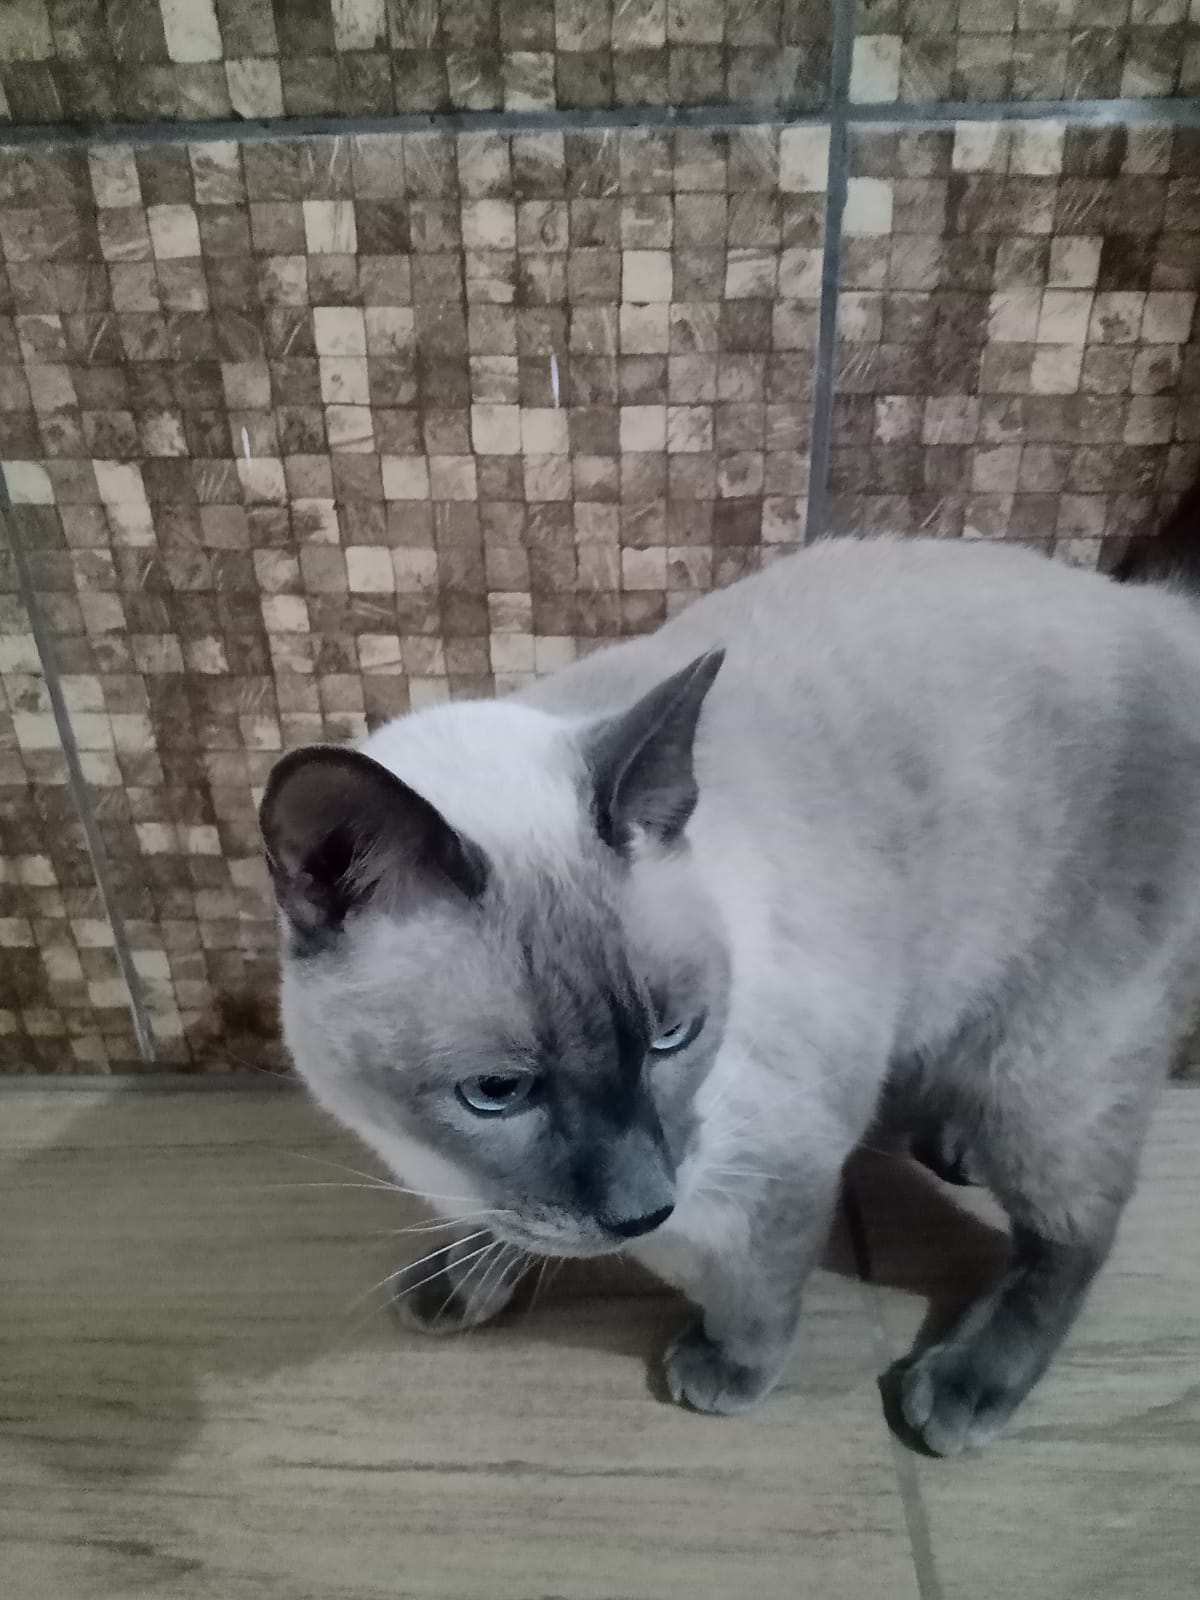

In [44]:
img

In [45]:
img.size

(1200, 1600)

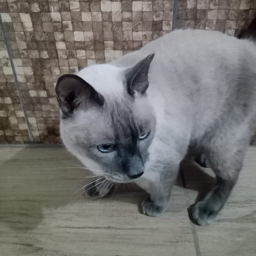

In [46]:
img = img.crop((0, 400, 1200, 1600))
x = img.resize((256, 256))
x

In [47]:
x = np.array(x)
x.shape, x.dtype

((256, 256, 3), dtype('uint8'))

In [48]:
m = x.mean(axis=(0,1))
v = x.var(axis=(0,1))
(x - m).mean(axis=(0,1))

array([0., 0., 0.])

In [49]:
def normalize_input(x):
    _mean = np.array([115., 114., 112.])
    _var = np.array([1450., 1510., 1700.])
    return (x - _mean) / np.sqrt(_var + 1e-10)

In [50]:
def denormalize_output(x_hat):
    _mean = np.array([115., 114., 112.])
    _var = np.array([1450., 1510., 1700.])
    x = x_hat * np.sqrt(_var + 1e-10) + _mean
    x = np.clip(x, a_min=0, a_max=255)
    return x

In [51]:
x0 = normalize_input(x)

## Encoder

In [65]:
encoder = Encoder(C=2, filters=128, n_blocks=5)

In [66]:
# so pra poder o batchnormalization funfar
encoder.compile(optimizer=optimizers.Adam(learning_rate=0.002), loss='mean_squared_error')
encoder.train_on_batch(np.array([x0]), np.ones((1, 32, 32, 2)))

array(1.9999999, dtype=float32)

In [67]:
w = encoder(np.array([x0]))
w = w.numpy()

In [68]:
np.mean(w[0, :, :, :], axis=(0, 1)), np.var(w[0, :, :, :], axis=(0, 1))

(array([0.15392187, 1.9544194 ], dtype=float32),
 array([0.91049564, 2.5999615 ], dtype=float32))

In [69]:
w[0, :, :, 0].min()

-3.4384425

In [70]:
w.shape

(1, 32, 32, 2)

## Quantizer

In [71]:
def quantizer(L, c_min, c_max):
    """
    z: ndarray(B, H, W, C)
    L: int
    """
    def q(z):
        # convert z -> (B, C, H, W)
        z_t = tf.transpose(z, (0, 3, 1, 2))
        z_t_shape = tf.shape(z_t)
        B, C = z_t_shape[:2]
        z_vec = tf.reshape(z_t, [B, C, -1, 1])
        # definir array centers
        centers = np.linspace(float(c_min), float(c_max), L)
        # definir tensor dist
        dist = tf.square(tf.abs(z_vec - centers))
        # calcular tensor z_hat
        symbols = tf.reshape(tf.argmin(dist, axis=-1), z_t_shape)
        symbols = tf.transpose(symbols, (0, 2, 3, 1))
        z_hat = tf.convert_to_tensor(centers[symbols])
        return z_hat, symbols
    return q

In [72]:
q = quantizer(5, -2, 2)
w_hat, symbols = q(w)

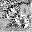

In [73]:
w_vis = np.uint8(63*(w_hat + 2))
Image.fromarray(w_vis[0])

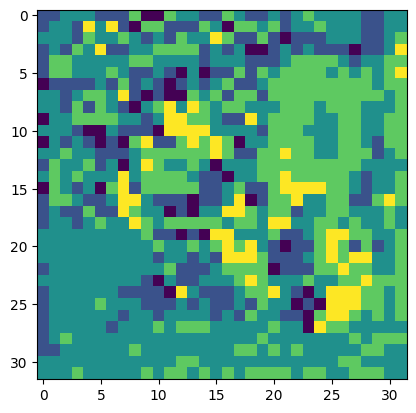

In [74]:
plt.imshow(w_vis[0,:,:,0])

## Generator

In [75]:
# generator = build_generator((32,32,2))
generator = Generator(filters=128, n_blocks=5)

In [77]:
generator.compile(optimizer=optimizers.Adam(), loss='mean_squared_error')
generator.train_on_batch(w_hat, np.ones((1, 256, 256, 3)))

array(1.9953179, dtype=float32)

In [78]:
w_hat.shape

TensorShape([1, 32, 32, 2])

In [79]:
x_hat = generator(w_hat).numpy()

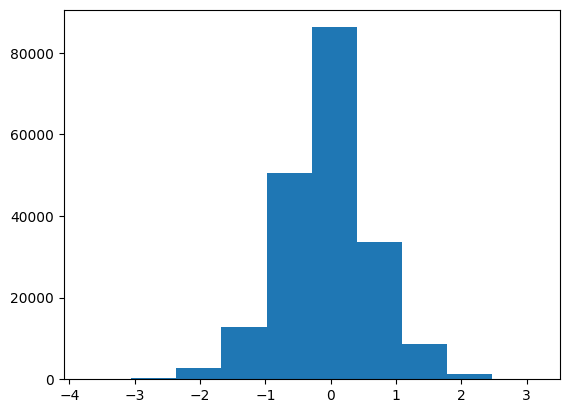

In [80]:
plt.hist(x_hat[0].ravel());

In [81]:
x_hat = np.uint8(denormalize_output(x_hat))

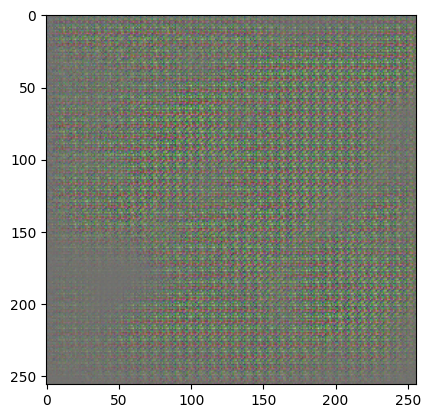

In [82]:
plt.imshow(x_hat[0])

## Discriminator

In [83]:
# disc = build_discriminator((256,256,3))
disc = Discriminator(filters=128)

In [84]:
disc.compile(optimizer=optimizers.Adam(), loss='mean_squared_error')
disc.train_on_batch(np.array([x]), np.array([1]))

array(0.41231304, dtype=float32)

In [85]:
disc(np.array([x])).numpy()

array([[2.1095989e-08]], dtype=float32)

## Dataset

In [ ]:
import scipy.io

In [ ]:
mat = scipy.io.loadmat('../cocostuff-10k-v1.1(1)/annotations/COCO_train2014_000000000077.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Apr  6 19:02:23 2017',
 '__version__': '1.0',
 '__globals__': [],
 'S': array([[157, 157, 157, ..., 169, 169, 169],
        [157, 157, 157, ..., 169, 169, 169],
        [157, 157, 157, ..., 169, 169, 169],
        ...,
        [116, 116, 116, ..., 116, 116, 116],
        [116, 116, 116, ..., 116, 116, 116],
        [116, 116, 116, ..., 116, 116, 116]], dtype=uint8),
 'captions': array([[array(['A young man riding a skateboard into the air.'], dtype='<U45')],
        [array(['a group of teenagers jumping a ramp on their skateboards'],
               dtype='<U56')                                                ],
        [array(['A time lapse image of a guy on a skate board.'], dtype='<U45')],
        [array(['Group of boys performing skateboard trick on ramp with graffiti on it'],
               dtype='<U69')                                                             ],
        [array(['some male skateboarders are

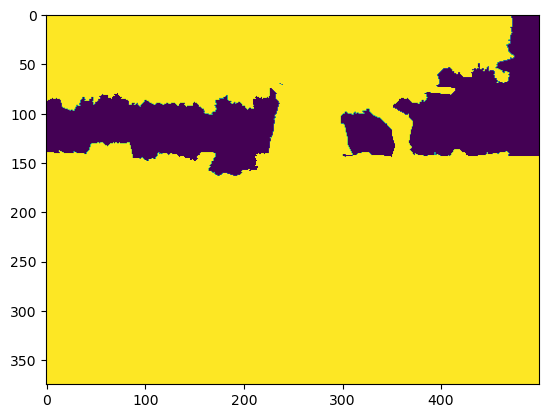

In [ ]:
x = mat['S'].copy()
x[x != 169] = 255
plt.imshow(x)

In [ ]:
np.unique(mat['S'])

array([  0,   1,  41,  96, 106, 113, 116, 157, 169], dtype=uint8)

## Modelo

In [87]:
class GenerativeCompressionGAN(models.Model):
    def __init__(self, encoder, generator, discriminator, num_centroids=5, lambda_recon=10, c_min = -2, c_max = 2):
        super(GenerativeCompressionGAN, self).__init__()
        self.encoder = encoder
        self.generator = generator
        self.discriminator = discriminator
        self.quantizer = quantizer(L=num_centroids, c_min = c_min, c_max = c_max)
        self.lambda_recon = lambda_recon  # Peso para a perda de distorção
        self.num_centroids = num_centroids  # Número de níveis de quantização

    def compile(self, d_optimizer, g_optimizer, gan_loss_fn, distortion_loss_fn):
        super(GenerativeCompressionGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.gan_loss_fn = gan_loss_fn  # Perda adversarial
        self.distortion_loss_fn = distortion_loss_fn  # Perda de distorção

    def __call__(self, data):
        real_images = normalize_input(data)
        # 1. Encode the image
        encoded_images = self.encoder(real_images)
        # 2. Quantize the latent space
        quantized_latent, _ = self.quantizer(encoded_images)
        # 3. Generate (Decode) image
        generated_images = self.generator(quantized_latent)
        return denormalize_output(generated_images), quantized_latent

    def train_step(self, data):
        real_images = normalize_input(data)

        # 1. Encode the image
        encoded_images = self.encoder(real_images)
        # 2. Quantize the latent space
        quantized_latent, _ = self.quantizer(encoded_images)
        # 3. Generate (Decode) image
        generated_images = self.generator(quantized_latent)

        # 4. Train the discriminator
        with tf.GradientTape() as tape:
            real_output = self.discriminator(real_images)
            fake_output = self.discriminator(generated_images)

            # Perda adversarial do discriminador
            d_loss_real = self.gan_loss_fn(tf.ones_like(real_output), real_output)
            d_loss_fake = self.gan_loss_fn(tf.zeros_like(fake_output), fake_output)
            d_loss = (d_loss_real + d_loss_fake) / 2

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # 5. Train the generator (GAN loss, distortion loss, entropy loss)
        with tf.GradientTape() as tape:
            generated_images = self.generator(quantized_latent)
            fake_output = self.discriminator(generated_images)

            # Perda adversarial para o gerador (Least-Squares GAN)
            g_gan_loss = self.gan_loss_fn(tf.ones_like(fake_output), fake_output)

            # Perda de distorção
            g_distortion_loss = self.distortion_loss_fn(real_images, generated_images)


            # Perda total ponderada
            g_loss = g_gan_loss + self.lambda_recon * g_distortion_loss

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [88]:
def least_squares_gan_loss(y_true, y_pred):
    return tf.reduce_mean((y_true - y_pred) ** 2)

In [89]:
# Build models
# encoder = build_encoder((256,256,3))
# generator = build_generator((32,32,2))
# discriminator = build_discriminator((256,256,3))
encoder = Encoder(C=2, filters=128, n_blocks=5)
generator = Generator(filters=128, n_blocks=5)
discriminator = Discriminator(filters=128)

# Instantiate and compile the GAN
gan = GenerativeCompressionGAN(encoder, generator, discriminator, num_centroids=5, lambda_recon=10)
gan.compile(
    d_optimizer=optimizers.Adam(learning_rate=0.0002),
    g_optimizer=optimizers.Adam(learning_rate=0.0002),
    gan_loss_fn=least_squares_gan_loss,
    distortion_loss_fn=tf.keras.losses.MeanAbsoluteError()
)

In [90]:
gan.train_step(tf.convert_to_tensor(np.array([x])))

{'d_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.3517945>,
 'g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=42.1961>}

In [91]:
xhat, what = gan(x[np.newaxis])

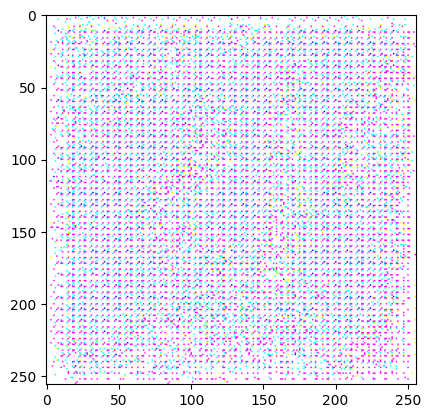

In [92]:
plt.imshow(xhat[0])

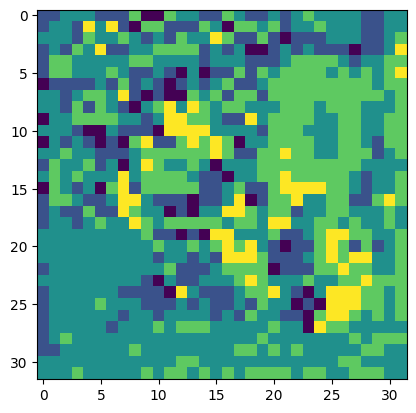

In [93]:
plt.imshow(w_hat[0, :, :, 0])